In [27]:
# coding=utf-8
from graph_tool.all import *
from girvan_newman import *
from sentence_pair_score import *
from resource_loader import *
from config import *
from util.nlp_utils import split_sentence
from util.list_utils import common, substract, remove_values_from_list

LANGUAGE = "Chinese"

IDF = load_IDF()
# STOPWORDS = load_stopwords(LANGUAGE)

EMPTY_VERTEX_NAME = ""
TITLE_VERTEX_NAME = "_TITLE_"

ALPHA = 0.1  # sentence score paragraph index decay parameter
BETA = 0.3  # sentence score sentence index decay parameter


def draw_ccig(g, fig_name):
    """
    Draw ccig to a file.
    :param g: concept community interaction graph.
    :param fig_name: output figure file.
    """
    c = label_components(g)[0]
    pos = sfdp_layout(g)
    graph_draw(g, pos=pos,
               vertex_text=g.vertex_properties["name"],
               vertex_fill_color=c,
               vertex_font_family="STKaiti",
               vertex_font_size=18,
               edge_font_family="STKaiti",
               edge_font_size=10,
               edge_text=g.edge_properties["name"],
               output_size=(1000, 1000),
               output=fig_name)


def print_ccig(g, sentences1, sentences2):
    """
    Print ccig.
    :param g: concept community interaction graph.
    :param sentences1: sentences from document 1.
    :param sentences2: sentences from document 2.
    """
    print("\n<graph>")
    for idx in range(g.num_vertices()):
        v = g.vertex(idx)
        idxs1 = list(set(g.vertex_properties["sentidxs1"][v]))
        idxs2 = list(set(g.vertex_properties["sentidxs2"][v]))
        text1 = [sentences1[i] for i in idxs1]
        text1 = "\n".join(text1)
        text2 = [sentences2[i] for i in idxs2]
        text2 = "\n".join(text2)
        print("<vertex>" + str(idx))
        print("Keywords: " + ",".join(g.vertex_properties["concepts"][v]))
        print("Sentences 1: ")
        print(text1)
        print("Sentences 2: ")
        print(text2)
        print("</vertex>" + str(idx))
    for e in g.edges():
        weight = g.edge_properties["weight_tfidf"][e]
        concepts = g.edge_properties["concepts"][e]
        concepts = ",".join(concepts)
        print("Edge (" + str(e.source()) + ", " + str(e.target()) + ")")
        print("Keywords: " + concepts)
        print("Weight: " + str(weight))
    print("num_v_L: " + str(g.graph_properties["num_v_L"]))
    print("num_v_R: " + str(g.graph_properties["num_v_R"]))
    print("num_v_LR: " + str(g.graph_properties["num_v_LR"]))
    print("match rate: " + str(g.graph_properties["num_v_LR"] / g.num_vertices()))
    print("</graph>\n")


def construct_cig(sentences, concepts):
    """
    Given a segmented text and a list of concepts,
    construct concept interaction graph.
    :param sentences: a list of sentences.
    :param concepts: a list of strings.
    :return: a concept interaction graph.
    """
    # initialize graph
    g = Graph(directed=False)
    concepts = list(set(concepts))
    if len(sentences) == 0:
        return g

    # initialize vertex properties
    vprop_name = g.new_vertex_property("string")
    vprop_sentidxs = g.new_vertex_property("vector<int32_t>")
    vertex_idx_map = {}

    # initialize empty vertex
    # used to contain sentences that have no concept
    v_empty = g.add_vertex()
    vprop_name[v_empty] = EMPTY_VERTEX_NAME
    vprop_sentidxs[v_empty] = []
    vertex_idx_map[EMPTY_VERTEX_NAME] = 0

    # create concept vertices
    i = 1
    for concept in concepts:
        v = g.add_vertex()
        vprop_name[v] = concept
        vprop_sentidxs[v] = []
        vertex_idx_map[concept] = i
        i = i + 1

    # create edges
    eprop_name = g.new_edge_property("string")
    eprop_sentidxs = g.new_edge_property("vector<int32_t>")
    eprop_weight = g.new_edge_property("double")
    for i in range(len(sentences)):
        sent = sentences[i]
        words = str(sent).split()
        is_sent_contain_concept = False
        for w in words:
            if w in concepts:
                is_sent_contain_concept = True
                # vertex_idx_map stores concept id
                vprop_sentidxs[g.vertex(vertex_idx_map[w])].append(i)
        if not is_sent_contain_concept:
            vprop_sentidxs[v_empty].append(i)

    # check whether two concepts share common sentences, if they do, add an edge
    for i in range(len(concepts)):
        vi_idx = vertex_idx_map[concepts[i]]
        for j in range(i + 1, len(concepts)):
            vj_idx = vertex_idx_map[concepts[j]]
            common_sentidxs = common(
                vprop_sentidxs[g.vertex(vi_idx)],
                vprop_sentidxs[g.vertex(vj_idx)])
            if len(common_sentidxs) > 0:
                e = g.add_edge(g.vertex(vi_idx), g.vertex(vj_idx))
                eprop_sentidxs[e] = common_sentidxs
                eprop_weight[e] = len(common_sentidxs)
                if concepts[i] < concepts[j]:
                    eprop_name[e] = concepts[i] + "_" + concepts[j]
                else:
                    eprop_name[e] = concepts[j] + "_" + concepts[i]

    for i in range(len(concepts)):
        vi_idx = vertex_idx_map[concepts[i]]
        vi_edges_idx = g.get_out_edges(vi_idx)  # edges ,i->something
        for j in range(vi_edges_idx.shape[0]):
            from_idx = vi_edges_idx[j, 0]
            to_idx = vi_edges_idx[j, 1]
            # 只剩下vi单独的句子而除去边上共有的句子
            vprop_sentidxs[g.vertex(vi_idx)] = substract(
                vprop_sentidxs[g.vertex(vi_idx)],
                eprop_sentidxs[g.edge(from_idx, to_idx)])

    # graph properties
    g.graph_properties["numsent"] = g.new_graph_property("double")
    g.graph_properties["numsent"] = len(sentences)

    # save properties as internal properties
    g.vertex_properties["name"] = vprop_name
    g.vertex_properties["sentidxs"] = vprop_sentidxs
    g.edge_properties["name"] = eprop_name
    g.edge_properties["sentidxs"] = eprop_sentidxs
    g.edge_properties["weight"] = eprop_weight

    return g


def get_concept_communities(sentences, concepts):
    # TODO: should read this
    """
    Given a segmented text and a list of concepts,
    construct concept graph and get concept communities.
    :param sentences: a list of sentences.
    :param concepts: a list of concepts.
    :return: a list of concept communities.
    """
    cig = construct_cig(sentences, concepts)
    new_cig = girvan_newman(cig, "name", "weight")
    all_c = label_components(new_cig)[0]
    distinct_c = set(all_c.a)
    concept_communities = []
    for c in distinct_c:
        vs = find_vertex(new_cig, all_c, c)
        vs_names = [new_cig.vertex_properties["name"][v] for v in vs]
        concept_communities.append(vs_names)

    # remove the empty node.
    concept_communities.remove([EMPTY_VERTEX_NAME])

    # remove small communities.
    concept_communities = [x for x in concept_communities
                           if len(x) >= 2]
    return concept_communities


def community2name(community):
    """
    Given a list of concepts (words), return a string as its name.
    """
    return " ".join(community)


def name2community(name):
    """
    Given the string name of a community, recover the community.
    """
    return str(name).split()


def assign_sentences_to_concept_communities(sentences,
                                            concept_communities):
    """
    Assign a list of sentences to different concept communities.
    :param sentences: a list of sentences
    :param concept_communities: a list of concept lists.
    :return: a dictionary of (community_name, sentence index list)
    """
    names = [community2name(c) for c in concept_communities]
    name_sentidxs = {}
    name_sentidxs[EMPTY_VERTEX_NAME] = []
    if len(names) == 0:
        print(concept_communities)
    for name in names:
        name_sentidxs[name] = []
    for i in range(len(sentences)):
        # NOTICE: make sure IDF contains all concepts
        scores = [tfidf_cos_sim(sentences[i], name, IDF) for name in names]
        max_index = scores.index(max(scores))
        max_score = max(scores)
        if max_score > 0:
            name_sentidxs[names[max_index]].append(i)
        else:
            name_sentidxs[EMPTY_VERTEX_NAME].append(i)
    return name_sentidxs


def assign_sentences_to_concepts(sentences, concepts):
    """
    Assign a list of sentences to different concept communities.
    :param sentences: a list of sentences
    :param concepts: a list of concepts.
    :return: a dictionary of (concept_name, sentence index list)
    """
    concept_sentidxs = {}
    concept_sentidxs[EMPTY_VERTEX_NAME] = []
    assigned_sentidxs = []
    for concept in concepts:
        concept_sentidxs[concept] = []
        for i in range(len(sentences)):
            words = str(sentences[i]).split()
            if concept in words:
                concept_sentidxs[concept].append(i)
                assigned_sentidxs.append(i)

    concept_sentidxs[EMPTY_VERTEX_NAME] = [x for x in range(len(sentences))
                                           if x not in assigned_sentidxs]
    return concept_sentidxs


def construct_ccig(sentences, concepts, title=None, use_cd=True):
    """
    Given a segmented text and a list of concepts,
    construct concept community interaction graph.
    :param sentences: a list of sentences.
    :param concepts: a list of concepts.
    :return: a concept community interaction graph.
    """
    # initialize graph
    g = Graph(directed=False)
    concepts = list(set(concepts))
    concepts = remove_values_from_list(concepts, EMPTY_VERTEX_NAME)
    if len(sentences) == 0 or len(concepts) == 0:
        print("No concept in concepts list.")
        return None
    if len(concepts) > 70:
        print("Too many concepts.")
        return None

    # get concept communities
    if use_cd:
        concept_communities = get_concept_communities(sentences, concepts)
        if len(concept_communities) <= 1:
            concept_communities = [[c] for c in concepts]
    else:
        concept_communities = [[c] for c in concepts]

    # assign sentences to communities
    if use_cd:
        cname_sentidxs = assign_sentences_to_concept_communities(
            sentences, concept_communities)
    else:
        cname_sentidxs = assign_sentences_to_concepts(sentences, concepts)

    # initialize vertex properties
    vprop_name = g.new_vertex_property("string")
    vprop_concepts = g.new_vertex_property("vector<string>")
    vprop_sentidxs = g.new_vertex_property("vector<int32_t>")
    concept_vertexidxs_map = {}  # keyword to community id
    for c in concepts:
        concept_vertexidxs_map[c] = []

    # initialize empty vertex
    # used to contain sentences that have no concept
    v_empty = g.add_vertex()
    vprop_name[v_empty] = EMPTY_VERTEX_NAME
    vprop_concepts[v_empty] = []
    vprop_sentidxs[v_empty] = cname_sentidxs[EMPTY_VERTEX_NAME]

    # create concept community vertices
    i = 1
    for community in concept_communities:
        cname = community2name(community)
        if len(cname_sentidxs[cname]) == 0:
            continue
        v = g.add_vertex()
        vprop_name[v] = cname
        vprop_concepts[v] = community
        vprop_sentidxs[v] = cname_sentidxs[cname]
        for concept in community:
            concept_vertexidxs_map[concept].append(i)
        i = i + 1

    # create edges
    eprop_name = g.new_edge_property("string")
    eprop_concepts = g.new_edge_property("vector<string>")
    eprop_sentidxs = g.new_edge_property("vector<int32_t>")
    eprop_weight_numsent = g.new_edge_property("double")
    eprop_weight_tfidf = g.new_edge_property("double")

    # edges by connective sentences
    for sent_idx in range(len(sentences)):
        sent = sentences[sent_idx]
        words = str(sent).split()
        intersect = set(words).intersection(set(concepts))
        if len(intersect) == 0:
            continue
        related_vertexidxs = []
        for c in intersect:
            related_vertexidxs.extend(concept_vertexidxs_map[c])  # extend community id
        related_vertexidxs = list(set(related_vertexidxs))
        num_related_v = len(related_vertexidxs)  # number of connected community
        if num_related_v < 2:
            continue
        # enumerate between the related communities, this means the two communities share at least this sentence
        for j in range(num_related_v):
            v1_idx = related_vertexidxs[j]
            for k in range(j, num_related_v):
                if j == k:
                    continue
                v2_idx = related_vertexidxs[k]
                source_idx = min(v1_idx, v2_idx)
                target_idx = max(v1_idx, v2_idx)
                e = g.edge(source_idx, target_idx)
                if e is None:
                    e = g.add_edge(source_idx, target_idx)
                    eprop_sentidxs[e] = [sent_idx]  # sentences that share keywords between communities
                    eprop_concepts[e] = list(intersect)  # shared keywords between two communities
                else:
                    old_idxs = eprop_sentidxs[e].a.tolist()
                    old_idxs.append(sent_idx)
                    eprop_sentidxs[e] = old_idxs
                    old_concepts = eprop_concepts[e]
                    old_concepts.extend(intersect)
                    eprop_concepts[e] = list(set(old_concepts))
    # assign vertex names and weights
    for e in g.edges():
        eprop_name[e] = " ".join(eprop_concepts[e])  # join by keywords
        eprop_weight_numsent[e] = float(len(eprop_sentidxs[e].a))  # shared sentence number
        eprop_weight_tfidf[e] = 0.0

    # edges by node text similarity
    WEIGHT_THRESHOLD = 0.001  # NOTICE: smaller threshold leads to more edges
    num_v = g.num_vertices()
    for i in range(num_v):
        for j in range(i, num_v):
            if j == i:
                continue
            v1 = g.vertex(i)
            v2 = g.vertex(j)
            idxs1 = list(set(vprop_sentidxs[v1]))
            idxs2 = list(set(vprop_sentidxs[v2]))
            text1 = [sentences[s] for s in idxs1]
            text1 = " ".join(text1)
            text2 = [sentences[s] for s in idxs2]
            text2 = " ".join(text2)
            w = tfidf_cos_sim(text1, text2, IDF)
            if w >= WEIGHT_THRESHOLD:
                e = g.edge(i, j)
                if e is None:
                    e = g.add_edge(i, j)
                    eprop_sentidxs[e] = []
                    eprop_concepts[e] = []
                    eprop_weight_numsent[e] = 0.0
                    eprop_name[e] = ""
                eprop_weight_tfidf[e] = w

    # if use title, create title vertex
    if title is not None:
        v_title = g.add_vertex()
        vprop_name[v_title] = TITLE_VERTEX_NAME
        vprop_sentidxs[v_title] = []
        vprop_concepts[v_title] = []

    # calculate vertex scores
    g.vertex_properties["pagerank"] = pagerank(g, weight=eprop_weight_tfidf)
    g.vertex_properties["betweenness"], g.edge_properties["betweenness"] = \
        betweenness(g, weight=eprop_weight_tfidf)
    g.vertex_properties["katz"] = katz(g, weight=eprop_weight_tfidf)

    # graph properties
    g.graph_properties["numsent"] = g.new_graph_property("double")
    g.graph_properties["numsent"] = len(sentences)

    # save properties as internal properties
    g.vertex_properties["name"] = vprop_name
    g.vertex_properties["concepts"] = vprop_concepts
    g.vertex_properties["sentidxs"] = vprop_sentidxs
    g.edge_properties["name"] = eprop_name
    g.edge_properties["weight_numsent"] = eprop_weight_numsent
    g.edge_properties["weight_tfidf"] = eprop_weight_tfidf
    g.edge_properties["concepts"] = eprop_concepts
    g.edge_properties["sentidxs"] = eprop_sentidxs

    return g


def construct_ccig_sentences(sentences, concepts):
    # my code
    # initialize graph
    g = Graph(directed=False)
    concepts = list(set(concepts))
    concepts = remove_values_from_list(concepts, EMPTY_VERTEX_NAME)
    if len(sentences) == 0 or len(concepts) == 0:
        print("No concept in concepts list.")
        return None
    if len(concepts) > 70:
        print("Too many concepts.")
        return None

    # get concept communities
    concept_communities = get_concept_communities(sentences, concepts)
    # assign sentences to communities
    community_name_sentidxs = assign_sentences_to_concept_communities(sentences, concept_communities)
    concept_name_sentidxs = assign_sentences_to_concepts(sentences, concepts)
    sentences_community_label = {}
    for cname in community_name_sentidxs:
        sent_ids = community_name_sentidxs[cname]
        for s_id in sent_ids:
            sentences_community_label[s_id] = cname
    sentences_concept_label = {}
    for cname in concept_name_sentidxs:
        sent_ids = concept_name_sentidxs[cname]
        for s_id in sent_ids:
            sentences_concept_label[s_id] = cname
    return sentences_community_label, sentences_concept_label


def construct_align_ccig(sentences1, sentences2,
                         concepts1, concepts2,
                         title1=None, title2=None, use_cd=True):
    num_sentences1 = len(sentences1)
    sentences = list(sentences1)
    sentences.extend(sentences2)
    concepts = list(concepts1)
    concepts.extend(concepts2)
    g = construct_ccig(sentences, concepts, title1, use_cd)
    if g is None:
        return None

    # vertices
    vprop_exist = g.new_vertex_property("string")  # "L" or "R" or "LR"
    vprop_sentidxs1 = g.new_vertex_property("vector<int32_t>")
    vprop_sentidxs2 = g.new_vertex_property("vector<int32_t>")
    for v in g.vertices():
        sentidxs = g.vertex_properties["sentidxs"][v].a.tolist()  # 属于v的所有句子
        sentidxs1 = [x for x in sentidxs if x < num_sentences1]  # 属于v的文章1的句子
        sentidxs2 = [x - num_sentences1 for x in sentidxs  # 属于v的文章2的句子
                     if x >= num_sentences1]
        vprop_sentidxs1[v] = sentidxs1
        vprop_sentidxs2[v] = sentidxs2
        if len(sentidxs1) > 0 and len(sentidxs2) > 0:
            vprop_exist[v] = "LR"
        elif len(sentidxs1) > 0:
            vprop_exist[v] = "L"
        elif len(sentidxs2) > 0:
            vprop_exist[v] = "R"
        else:
            vprop_exist[v] = "NULL"

    # edges
    eprop_exist = g.new_edge_property("string")  # "L" or "R" or "LR"
    eprop_sentidxs1 = g.new_edge_property("vector<int32_t>")
    eprop_sentidxs2 = g.new_edge_property("vector<int32_t>")
    for e in g.edges():
        sentidxs = g.edge_properties["sentidxs"][e].a.tolist()  # 共同包含的句子
        sentidxs1 = [x for x in sentidxs if x < num_sentences1]
        sentidxs2 = [x - num_sentences1 for x in sentidxs
                     if x >= num_sentences1]
        eprop_sentidxs1[e] = sentidxs1
        eprop_sentidxs2[e] = sentidxs2
        if len(sentidxs1) > 0 and len(sentidxs2) > 0:
            eprop_exist[e] = "LR"
        elif len(sentidxs1) > 0:
            eprop_exist[e] = "L"
        elif len(sentidxs2) > 0:
            eprop_exist[e] = "R"
        else:
            eprop_exist[e] = "NULL"

    # graph properties
    g.graph_properties["num_v_L"] = g.new_graph_property("double")
    g.graph_properties["num_v_L"] = len(find_vertex(g, vprop_exist, "L"))
    g.graph_properties["num_v_R"] = g.new_graph_property("double")
    g.graph_properties["num_v_R"] = len(find_vertex(g, vprop_exist, "R"))
    g.graph_properties["num_v_LR"] = g.new_graph_property("double")
    g.graph_properties["num_v_LR"] = len(find_vertex(g, vprop_exist, "LR"))

    # save properties as internal properties
    g.vertex_properties["exist"] = vprop_exist
    g.vertex_properties["sentidxs1"] = vprop_sentidxs1
    g.vertex_properties["sentidxs2"] = vprop_sentidxs2
    g.edge_properties["exist"] = eprop_exist
    g.edge_properties["sentidxs1"] = eprop_sentidxs1
    g.edge_properties["sentidxs2"] = eprop_sentidxs2

    return g


def text_pair2ccig(text1, text2,
                   concepts1, concepts2,
                   title1=None, title2=None, use_cd=True):
    """
    Given a pair of segmented texts and concepts lists,
    get ccig.
    :param text1: segmented text.
    :param concepts1: a list of concept words.
    :param text2: segmented text.
    :param concepts2: a list of concept words.
    :return: sentence lists of text1 and text2, and ccig.
    """
    sentences1 = split_sentence(text1, LANGUAGE)
    sentences2 = split_sentence(text2, LANGUAGE)
    g = construct_align_ccig(sentences1, sentences2,
                             concepts1, concepts2,
                             title1, title2, use_cd)
    return g, sentences1, sentences2



Vocabularies loaded: 206284
loaded IDF ...


In [26]:
text = "中国 在 看 日本 . \
         韩国 不听 中国 . \
         中国 靠近 俄国 . \
         俄国 远离 韩国 . \
         韩国 仇视 日本 . \
         日本 亲近 美国 . \
         日本 亲近 美国 . \
         日本 亲近 美国 . \
         美国 和 加拿大 接壤 . \
         加拿大 不熟悉 泰国 . \
         美国 不鸟 泰国 . \
         泰国 靠近 越南 . \
         越南 靠近 老挝 . \
         泰国 靠近 老挝 . \
         美国 自己 玩 . \
         新加坡 非常 小 . \
         新加坡 靠近 中国 。\
         哈哈 哈哈"
concepts = ["中国", "日本", "韩国", "美国", "新加坡",
                "俄国", "泰国", "老挝", "越南", "加拿大", ""]
sentences = split_sentence(text, LANGUAGE)
g = construct_ccig(sentences, concepts, use_cd=True)
draw_ccig(g, "ccig.pdf")
g = construct_ccig(sentences, concepts, use_cd=False)
draw_ccig(g, "cig.pdf")

print(assign_sentences_to_concepts(split_sentence(text, LANGUAGE), concepts))

{'': [1], '中国': [0], '日本': [0], '韩国': [0], '美国': [0], '新加坡': [0], '俄国': [0], '泰国': [0], '老挝': [0], '越南': [0], '加拿大': [0]}


In [6]:
sentences

['中国 在 看 日本 . 韩国 不听 中国 . 中国 靠近 俄国 . 俄国 远离 韩国 . 韩国 仇视 日本 . 日本 亲近 美国 . 日本 亲近 美国 . 日本 亲近 美国 . 美国 和 加拿大 接壤 . 加拿大 不熟悉 泰国 . 美国 不鸟 泰国 . 泰国 靠近 越南 . 越南 靠近 老挝 . 泰国 靠近 老挝 . 美国 自己 玩 . 新加坡 非常 小 . 新加坡 靠近 中国 。',
 '哈哈 哈哈']

In [33]:
from textrank4zh import TextRank4Keyword, TextRank4Sentence
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl



f = open('./new.txt', mode='r', encoding='utf-8')
text = f.read()
f.close()


In [34]:
text

'马拉松 递 国旗 事件 ， 中国田协 约见 主办方 ： 任何 仪式 不得 影响 比赛", "text": "Hi ~ ~ 大家 好 ， 我 是 今天 给 大家 带来 文章 的 小编 ， 在 说 今天 的 精彩 赛事 之前 先给 大家 简单 的 说 一下 体育运动 的 好处 吧 ， 20 世纪 以来 ， 随着 全球化 的 发展 和 我国 体育事业 改革 的 推进 ， 各类 新兴 体育运动 开始 进入 人们 的 视野 。 1995 年 《 全民健身计划纲要 》 和 2011 年 《 全民健身计划 》 的 颁布实施 ， 使得 城乡居民 体育 健身 意识 进一步 增强 ， 参加 体育锻炼 的 人数 显著 增加 ， 掀起 了 全民健身 热潮 ， 同时 ， 城乡居民 对 体育运动 的 形式 和 内容 也 提出 了 新 的 要求 和 标准 ， 青少年 喜欢 追求 时尚 ， 当然 也 喜欢 追求 新 的 运动 项目 ， 新兴 体育运动 应运而生 。   体育锻炼 时 常常 要求 身体 完成 一些 比 日常生活 更为 复杂 的 任务 神经系   统 必须 为此 高度 发挥 出 自己 的 机能 来 适应 这些 任务 的 要求 。 锻炼 能 促进 血液循环 ， 改善 大脑 的 营养 供给 ， 增加 大脑 的 重量 和 大脑皮层 的 厚度 ， 为 提高 学习 提供 充沛 的 体力 和 精力 。 这 就是 增加 体育运动 的 好处 ， 让 我们 一起 开始 看 今天 的 精彩内容 吧 马拉松 递 国旗 事件 ， 中国田协 约见 主办方 ： 任何 仪式 不得 影响 比赛 最近 苏州 马拉松 递 国旗 事件 在 网上 闹 得 沸沸扬扬 ， 中国 马拉松 运动员 何引丽 在 与 非洲 选手 争夺 冠军 时 ， 有 志愿者 分别 两次 进入 赛道 递 国旗 ， 最后 何引丽 以 5 秒 之 差 夺得 亚军 。 此后 ， 志愿者 和 运动员 何引丽 被 推到 舆论 的 风口浪尖 。 北京时间 11 月 29 日 ， 中国田径协会 召开 “ 奔跑中国 ” 马拉松 系列赛 组委会 工作汇报 会 ， 要求 高度 高度重视 竞赛 组织 工作 、 严肃 赛风 赛纪 。 “ 奔跑中国 ” 马拉松 系列赛 还 将 举行 5 场 比赛 ， 国家体育总局 主任 水涛 在 会上 传达 了 中国田协 近日 发布 的 《 

关键词：
马拉松 0.023244849153995644
大家 0.01664139743305039
国旗 0.016372212894680285
比赛 0.015914943621876586
递 0.01505727687525354
编 0.01489899503121927
要求 0.014241866926634436
体育运动 0.013875281795892695
何引丽 0.011972080540712686
影响 0.011698716766985705


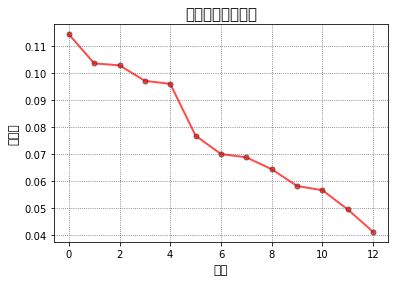

In [35]:
tr4w = TextRank4Keyword()
tr4w.analyze(text=text, lower=True, window=5)
print('关键词：')
concepts = ['']
for item in tr4w.get_keywords(10, word_min_len=1):
    print(item['word'], item['weight'])
    concepts.append(item['word'])

tr4s = TextRank4Sentence()
tr4s.analyze(text=text, lower=True, source = 'no_stop_words')
data = pd.DataFrame(data=tr4s.key_sentences)
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(facecolor='w')
plt.plot(data['weight'], 'ro-', lw=2, ms=5, alpha=0.7, mec='#404040')
plt.grid(b=True, ls=':', color='#606060')
plt.xlabel('句子', fontsize=12)
plt.ylabel('重要度', fontsize=12)
plt.title('句子的重要度曲线', fontsize=15)
plt.show()

In [31]:
key_sentences = tr4s.get_key_sentences(num=10, sentence_min_len=2)
for sentence in key_sentences:
    print(sentence['weight'], sentence['sentence'])

0.11439431564287622 这 就是 增加 体育运动 的 好处 ， 让 我们 一起 开始 看 今天 的 精彩内容 吧 马拉松 递 国旗 事件 ， 中国田协 约见 主办方 ： 任何 仪式 不得 影响 比赛 最近 苏州 马拉松 递 国旗 事件 在 网上 闹 得 沸沸扬扬 ， 中国 马拉松 运动员 何引丽 在 与 非洲 选手 争夺 冠军 时 ， 有 志愿者 分别 两次 进入 赛道 递 国旗 ， 最后 何引丽 以 5 秒 之 差 夺得 亚军
0.10361574193644506 马拉松 递 国旗 事件 ， 中国田协 约见 主办方 ： 任何 仪式 不得 影响 比赛", "text": "Hi ~ ~ 大家 好 ， 我 是 今天 给 大家 带来 文章 的 小编 ， 在 说 今天 的 精彩 赛事 之前 先给 大家 简单 的 说 一下 体育运动 的 好处 吧 ， 20 世纪 以来 ， 随着 全球化 的 发展 和 我国 体育事业 改革 的 推进 ， 各类 新兴 体育运动 开始 进入 人们 的 视野
0.10289020161921661 这次 会议 再次 表明 马拉松 递 国旗 事件 的 严重性 ， 这次 事件 引起 社会各界 广泛 关注 ， 马拉松 运营 方 智美 体育 集团 再次 打脸 ， 之前 还 拒绝 承认错误 ， 这次 会议 再次 说明 递 国旗 这样 的 做法 是 违反 体育 公平竞争 的 行为 ， 任何 仪式 和 活动 都 不得 影响 比赛 的 正常 进行 ， 这次 会议 对于 今年 余下 的 所有 马拉松 赛事 的 组委会 都 是 一次 重要 的 提醒
0.09715357737602597 这次 中国田协 再次 约见 “ 递 国旗 ” 赛事 主办方 ， 谈到 了 这次 竞赛活动 中 出现 的 违反 赛风 赛纪 的 问题 ， 给予 了 有关 部门 重要 的 提醒 ， 在 接下来 的 比赛 中 ， 要 杜绝 所有 违规 问题 出现 ， 强调 任何 仪式 和 活动 不得 影响 比赛 的 正常 进行 ， 不得 影响 选手 公平竞争
0.09603167231627198 “ 奔跑中国 ” 马拉松 系列赛 还 将 举行 5 场 比赛 ， 国家体育总局 主任 水涛 在 会上 传达 了 中国田协 近日 发布 的 《 关于 进一步 规范 、 加强 全国 马拉松 赛事 

In [36]:
concepts

['', '马拉松', '大家', '国旗', '比赛', '递', '编', '要求', '体育运动', '何引丽', '影响']

In [37]:
sentences = split_sentence(text, LANGUAGE)
g = construct_ccig(sentences, concepts, use_cd=True)
draw_ccig(g, "ccig.pdf")
g = construct_ccig(sentences, concepts, use_cd=False)
draw_ccig(g, "cig.pdf")

print(assign_sentences_to_concepts(split_sentence(text, LANGUAGE), concepts))

{'': [4, 12], '马拉松': [0, 5, 7, 8, 9], '大家': [1, 13], '国旗': [0, 5, 9, 10, 11], '比赛': [5, 8, 9, 10, 11], '递': [0, 5, 9, 10, 11], '编': [], '要求': [2, 3, 7], '体育运动': [1, 2, 5], '何引丽': [5, 6, 10], '影响': [0, 5, 8, 9, 10, 11]}
